# **Install dependencies**

In [ ]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.2 MB/s eta 0:00:00


# **Import dependencies**

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import itertools
import tensorflow as tf
from tensorflow.keras import regularizers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
import cv2
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping


# **Create folders**

In [ ]:
!mkdir dataset
!mkdir dataset/bicon
!mkdir dataset/neodent
!mkdir dataset/straumann
!mkdir dataset/biomet_3i
!mkdir dataset/zimmer
!mkdir dataset/biohorizons

# **Organize dataset**

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path in Drive where the image folders are located
source_root = '/content/drive/MyDrive/Pattern Recognition and ML/Pattern_project/data_set'

# Destination route in the Colab area
target_root = '/content'

# List of folders (classes)
folders = ['neodent', 'straumann', 'bicon', 'biomet_3i', 'zimmer', 'biohorizons']

for folder in folders:
    source_folder = os.path.join(source_root, folder)
    target_folder = os.path.join(target_root, folder)

    # Make sure that the destination folder exists
    os.makedirs(target_folder, exist_ok=True)

    # Iterate over and copy files
    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            source_path = os.path.join(source_folder, filename)
            target_path = os.path.join(target_folder, filename)

            try:
                shutil.copy2(source_path, target_path)
            except Exception as e:
                print(f"Error copying {filename}: {e}")

print("Copy finished.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copy finished.


In [ ]:
# TO MAKE SURE THAT EACH FOLDER HAS THE SAME SIZE -> IMPORTANT !!!!

# Base path where the folders are located
base_path = '/content'

# List of folders (classes)
folders = ['neodent', 'straumann', 'bicon', 'biomet_3i', 'zimmer', 'biohorizons']

# Count images in each class
for folder in folders:
    folder = folder.strip()  # Remove extra spaces
    folder_path = os.path.join(base_path, folder)

    if os.path.exists(folder_path):
        imagenes = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"{folder}: {len(imagenes)} images")
    else:
        print(f"{folder}: folder not found")

neodent: 49 images
straumann: 49 images
bicon: 49 images
biomet_3i: 49 images
zimmer: 49 images
biohorizons: 49 images


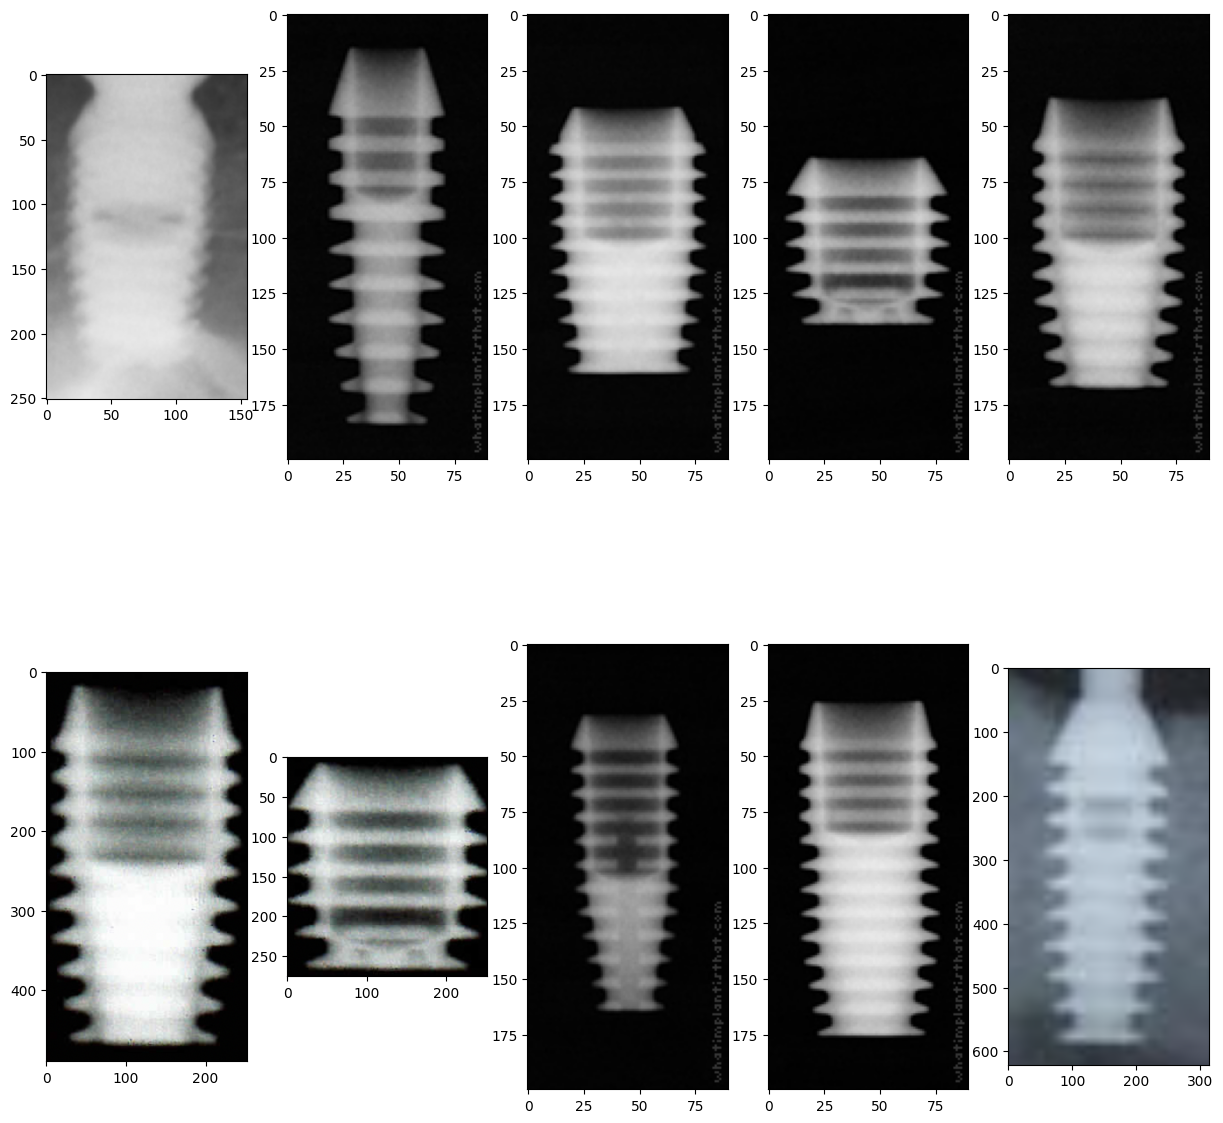

In [ ]:
# Show some pictures

plt.figure(figsize=(15,15))

carpeta = '/content/bicon'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:10]):
  plt.subplot(2,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [ ]:
# Root directory of the original folders
carpeta_fuente_root = '/content'
# Root directory of the destination folders
carpeta_destino_root = '/content/dataset'

# Ensure that the target parent folder exists.
os.makedirs(carpeta_destino_root, exist_ok=True)

# Maximum number of images per class (adjust according to the minimum number of images you have checked)
max_imgs = 400

for carpeta in folders:
    carpeta_fuente = os.path.join(carpeta_fuente_root, carpeta)
    carpeta_destino = os.path.join(carpeta_destino_root, carpeta)
    os.makedirs(carpeta_destino, exist_ok=True)

    imagenes = [img for img in os.listdir(carpeta_fuente) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    imagenes = imagenes[:max_imgs]  # Limit to 400 images per class

    for nombreimg in imagenes:
        ruta_origen = os.path.join(carpeta_fuente, nombreimg)
        img = cv2.imread(ruta_origen)

        if img is not None:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # GRAYSCALE
            ruta_destino = os.path.join(carpeta_destino, nombreimg)
            cv2.imwrite(ruta_destino, img_gray)
        else:
            print(f"The image could not be read: {ruta_origen}")

print("Process completed: all images copied and converted to grayscale.")

Process completed: all images copied and converted to grayscale.


# **Data augmentation**

In [ ]:
# Data augmentation with ImageDataGenerator for grayscale imaging

datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values to range [0,1]
    rotation_range=15,                 # Random rotation range in degrees (-15 to +15)
    width_shift_range=0.2,             # Random horizontal shift (20% of width)
    height_shift_range=0.2,            # Random vertical shift (20% of height)
    shear_range=10,                    # Angular deformation intensity (in degrees)
    zoom_range=[0.9, 1.8],             # Random zoom range (90% to 180%) (used to be 0.5 - 1.5 but 0.5 makes the implant not visible in the image)
    brightness_range=[0.85, 1.15],     # Brightness adjustment range (85% to 115%)
    fill_mode='constant',  cval=0,     # Strategy to fill spaces created by transformations (used to be reflect)
    horizontal_flip=True,              # Random horizontal flip
    vertical_flip=True,                # Random vertical flip
    validation_split=0.2
)

# Generators for training and test sets
data_gen_entrenamiento = datagen.flow_from_directory(
    '/content/dataset',
    target_size=(200, 200),
    batch_size=100,
    shuffle=True,
    subset='training',
    color_mode='grayscale',
    class_mode='categorical'
)

data_gen_pruebas = datagen.flow_from_directory(
    '/content/dataset',
    target_size=(200, 200),
    batch_size=100,
    shuffle=True,
    subset='validation',
    color_mode='grayscale',
    class_mode='categorical'
)

Found 240 images belonging to 6 classes.
Found 54 images belonging to 6 classes.


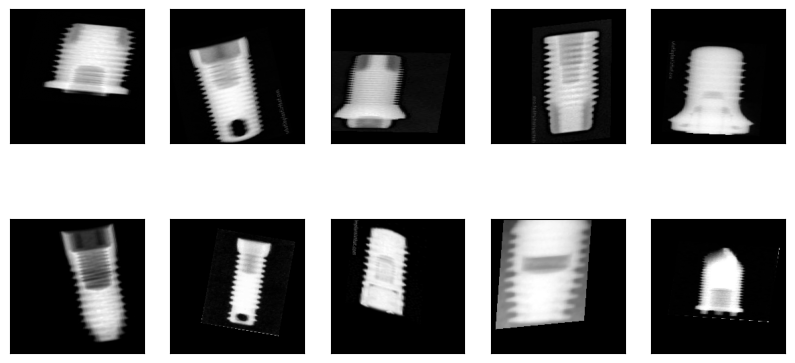

In [ ]:
# Print 10 images of the training generator
for imagen, etiqueta in data_gen_entrenamiento:
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        # Display the image in grayscale
        plt.imshow(imagen[i].squeeze(), cmap='gray')
    plt.show()
    break


# **Neural Network Model**

In [ ]:
def create_model():
  modelo = tf.keras.models.Sequential([
      # Block 1
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 1)),
      tf.keras.layers.MaxPooling2D(2, 2),

      # Block 2
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),

      # Block 3
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),

      # Final layers
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(6, activation='softmax')
  ])

  # Compilation with adjusted learning rate
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  modelo.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return modelo

# **Train Model**

In [ ]:
print("Training model...");
epocas=100
modelo = create_model()
history = modelo.fit(
    data_gen_entrenamiento,
    epochs=epocas,
    validation_data=data_gen_pruebas,
    batch_size=100

)

print("Model trained!");

Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 945ms/step - accuracy: 0.1675 - loss: 1.8425 - val_accuracy: 0.2222 - val_loss: 1.8203
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - accuracy: 0.2158 - loss: 1.7980 - val_accuracy: 0.1852 - val_loss: 1.8174
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step - accuracy: 0.1783 - loss: 1.7923 - val_accuracy: 0.2037 - val_loss: 1.7821
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.1997 - loss: 1.7808 - val_accuracy: 0.1481 - val_loss: 1.7763
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step - accuracy: 0.1954 - loss: 1.7822 - val_accuracy: 0.1481 - val_loss: 1.8007
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 509ms/step - accuracy: 0.1858 - loss: 1.7776 - val_accuracy: 0.2593 - val_loss: 1.7539
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.1964 - loss: 1.7618 - val_accuracy: 0.1852 - val_loss: 1.7516
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.2387 - loss: 1.7532 - val_accuracy: 0.2778 - v

# **Training Results**

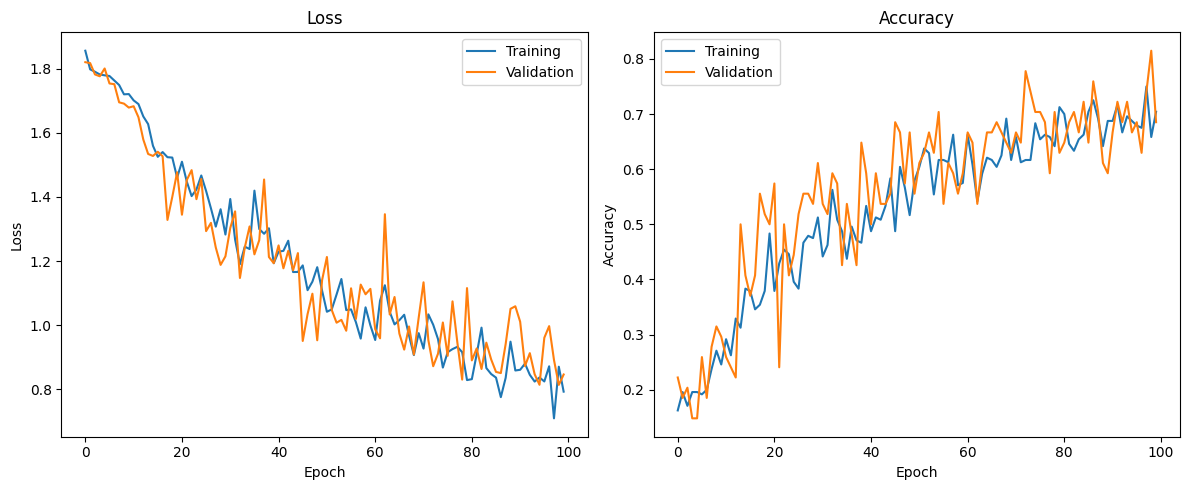

In [ ]:
# Create a figure with 2 subplots (one for loss and one for accuracy)
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


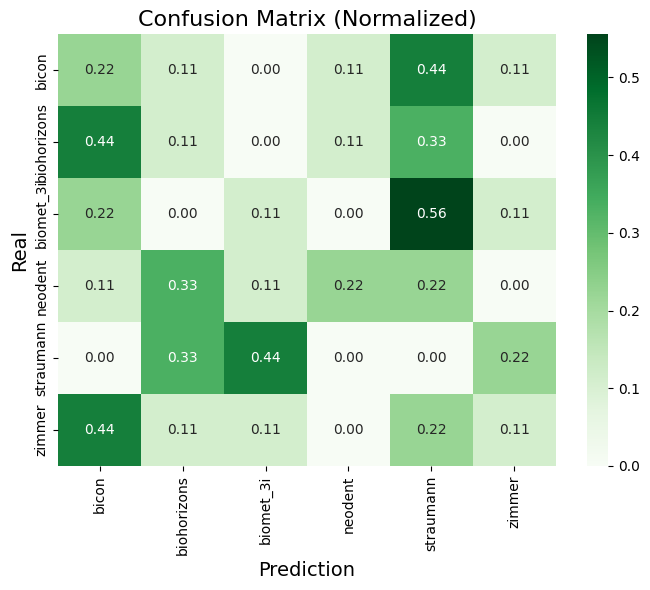

In [ ]:
# Get predictions on the entire validation set
# Disable progress bar to avoid visual clutter
y_pred_probs = modelo.predict(data_gen_pruebas, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted classes

# Get the true tags (convert one-hot to index)
y_true = data_gen_pruebas.classes  # are already in integer format

# Get class names in correct order
class_names = list(data_gen_pruebas.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display
plt.figure(figsize=(7, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.title('Confusion Matrix (Normalized)', fontsize=16)
plt.tight_layout()
plt.show()

# **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


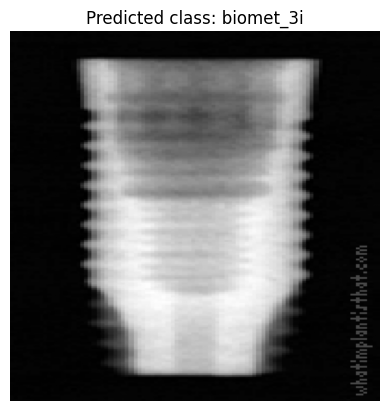

In [ ]:
def predict_image(image_path, model):
    # Load the image and preprocess it
    img = image.load_img(image_path, target_size=(200, 200), color_mode='grayscale')
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize

    # Perform prediction
    classes = model.predict(x)
    predicted_class = np.argmax(classes)

    # Get class labels
    class_labels = list(data_gen_entrenamiento.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    # Show image with label predicted
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted class: {predicted_label}')
    plt.axis('off')
    plt.show()

image_path_to_predict = '/content/biomet_3i/Full-OSSEOTITE-Parallel-Walled-Certain.jpg'  # Change by the route of your image
predict_image(image_path_to_predict, modelo)

# **Grad-CAM**

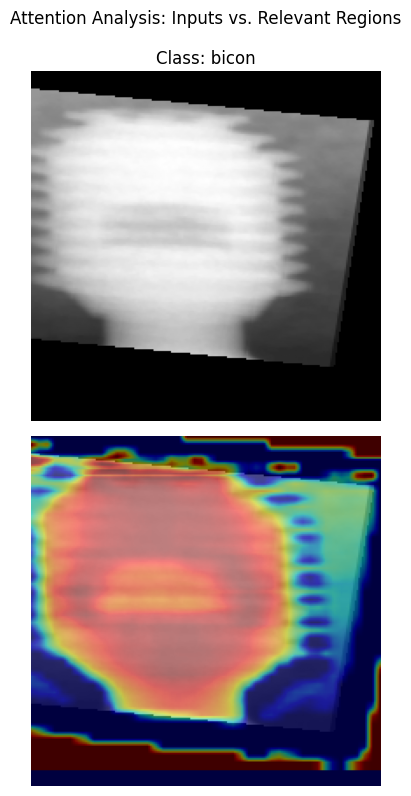

In [ ]:
# Information in https://keisen.github.io/tf-keras-vis-docs/

# Function to obtain predicted class score
def score(output):
    return [output[i, np.argmax(output[i])] for i in range(len(output))]

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

# Get batch from training generator (with magnification)
X_train, y_train = next(data_gen_entrenamiento)
images = X_train[:1]  # 1 example

# Configure GradCAM
gradcam = Gradcam(modelo, model_modifier=model_modifier_function(modelo), clone=True)

# Generate heatmaps (use last convolutional layer)
last_conv_layer = next(layer for layer in reversed(modelo.layers)
                    if isinstance(layer, tf.keras.layers.Conv2D))

cam = gradcam(score, images, penultimate_layer=last_conv_layer.name)

# Implant visualization
class_names = list(data_gen_entrenamiento.class_indices.keys())
plt.figure(figsize=(15, 8))

for i in range(1):
    # Original image with magnification
    plt.subplot(2, 1, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Class: {class_names[np.argmax(y_train[i])]}')
    plt.axis('off')

    # Heatmap
    plt.subplot(2, 1, i+2)
    heatmap = normalize(cam[i])
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')

plt.suptitle('Attention Analysis: Inputs vs. Relevant Regions', y=0.99)
plt.tight_layout()
plt.show()

# **K-Fold Cross-Validation**

In [ ]:
image_paths = []
labels = []

for class_name in folders:
    class_dir = os.path.join('/content/dataset', class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

df = pd.DataFrame({
    'filename': image_paths,
    'class': labels
})
k = 5  # Folds number
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

histories = []
fold = 1

for train_idx, val_idx in skf.split(df['filename'], df['class']):
    print(f"\nTraining Fold {fold}/{k}")

    # Clean last session
    tf.keras.backend.clear_session()

    # Create new generators for this fold
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(200, 200),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=100,
        shuffle=True
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(200, 200),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=100,
        shuffle=False
    )

    # Create and train model
    model = create_model()
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=val_generator,
        verbose=1,
        batch_size=100
    )

    histories.append(history)
    fold += 1

print("Complete training with K-Fold Cross Validation!")


Training Fold 1/5
Found 235 validated image filenames belonging to 6 classes.
Found 59 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.1536 - loss: 1.8655 - val_accuracy: 0.1186 - val_loss: 1.8042
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step - accuracy: 0.1644 - loss: 1.7970 - val_accuracy: 0.2373 - val_loss: 1.7812
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.1523 - loss: 1.7927 - val_accuracy: 0.2373 - val_loss: 1.7841
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - accuracy: 0.2318 - loss: 1.7803 - val_accuracy: 0.2203 - val_loss: 1.7826
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - accuracy: 0.1765 - loss: 1.7795 - val_accuracy: 0.1695 - val_loss: 1.7816
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - accuracy: 0.2307 - loss: 1.7642 - val_accuracy: 0.1695 - val_loss: 1.7881
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - accuracy: 0.2300 - loss: 1.7491 - val_accuracy: 0.2034 - val_loss: 1.7626
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - accuracy: 0.2796 - loss: 1.7079 - val_accuracy: 0.1356 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1546 - loss: 1.8447 - val_accuracy: 0.2203 - val_loss: 1.7865
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 513ms/step - accuracy: 0.1925 - loss: 1.7861 - val_accuracy: 0.2542 - val_loss: 1.7945
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.2795 - loss: 1.7665 - val_accuracy: 0.2034 - val_loss: 1.7783
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - accuracy: 0.2095 - loss: 1.7630 - val_accuracy: 0.2712 - val_loss: 1.7587
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - accuracy: 0.2703 - loss: 1.7462 - val_accuracy: 0.2203 - val_loss: 1.7615
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step - accuracy: 0.2204 - loss: 1.7636 - val_accuracy: 0.1695 - val_loss: 1.7736
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - accuracy: 0.2603 - loss: 1.7398 - val_accuracy: 0.2373 - val_loss: 1.7069
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step - accuracy: 0.2795 - loss: 1.7169 - val_accuracy: 0.3220 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 988ms/step - accuracy: 0.1406 - loss: 1.9644 - val_accuracy: 0.1695 - val_loss: 1.8086
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 0.2101 - loss: 1.7940 - val_accuracy: 0.1695 - val_loss: 1.7974
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.1792 - loss: 1.7830 - val_accuracy: 0.1695 - val_loss: 1.8015
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - accuracy: 0.1683 - loss: 1.7851 - val_accuracy: 0.2373 - val_loss: 1.7886
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step - accuracy: 0.1603 - loss: 1.7855 - val_accuracy: 0.2203 - val_loss: 1.7896
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 672ms/step - accuracy: 0.1834 - loss: 1.7894 - val_accuracy: 0.1695 - val_loss: 1.7859
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.2469 - loss: 1.7809 - val_accuracy: 0.2203 - val_loss: 1.7774
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step - accuracy: 0.2406 - loss: 1.7820 - val_accuracy: 0.1864 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1088 - loss: 1.8419 - val_accuracy: 0.1864 - val_loss: 1.7643
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - accuracy: 0.2309 - loss: 1.7755 - val_accuracy: 0.1356 - val_loss: 1.7863
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.1895 - loss: 1.7755 - val_accuracy: 0.1695 - val_loss: 1.7819
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.1592 - loss: 1.7776 - val_accuracy: 0.2034 - val_loss: 1.7724
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.2826 - loss: 1.7589 - val_accuracy: 0.2712 - val_loss: 1.7333
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.2353 - loss: 1.7641 - val_accuracy: 0.2542 - val_loss: 1.6847
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - accuracy: 0.2477 - loss: 1.7342 - val_accuracy: 0.2881 - val_loss: 1.6932
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.2977 - loss: 1.6958 - val_accuracy: 0.2203 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.1950 - loss: 1.8181 - val_accuracy: 0.2931 - val_loss: 1.7601
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step - accuracy: 0.2497 - loss: 1.7468 - val_accuracy: 0.2586 - val_loss: 1.7242
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.2303 - loss: 1.7525 - val_accuracy: 0.2931 - val_loss: 1.7298
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.2117 - loss: 1.7333 - val_accuracy: 0.2586 - val_loss: 1.7429
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step - accuracy: 0.2230 - loss: 1.7475 - val_accuracy: 0.1897 - val_loss: 1.7186
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.2015 - loss: 1.7680 - val_accuracy: 0.1207 - val_loss: 1.7444
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step - accuracy: 0.2585 - loss: 1.7043 - val_accuracy: 0.2414 - val_loss: 1.7517
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.2492 - loss: 1.7363 - val_accuracy: 0.3793 - val_

In [ ]:
# Calculate average metrics between folds
val_acc = [h.history['val_accuracy'][-1] for h in histories]
val_loss = [h.history['val_loss'][-1] for h in histories]

print(f"\nFinal Results ({k}-fold CV):")
print(f"Accuracy validation: {np.mean(val_acc):.2f} ± {np.std(val_acc):.2f}")
print(f"Loss validation: {np.mean(val_loss):.2f} ± {np.std(val_loss):.2f}")


Final Results (5-fold CV):
Accuracy validation: 0.64 ± 0.05
Loss validation: 0.99 ± 0.10


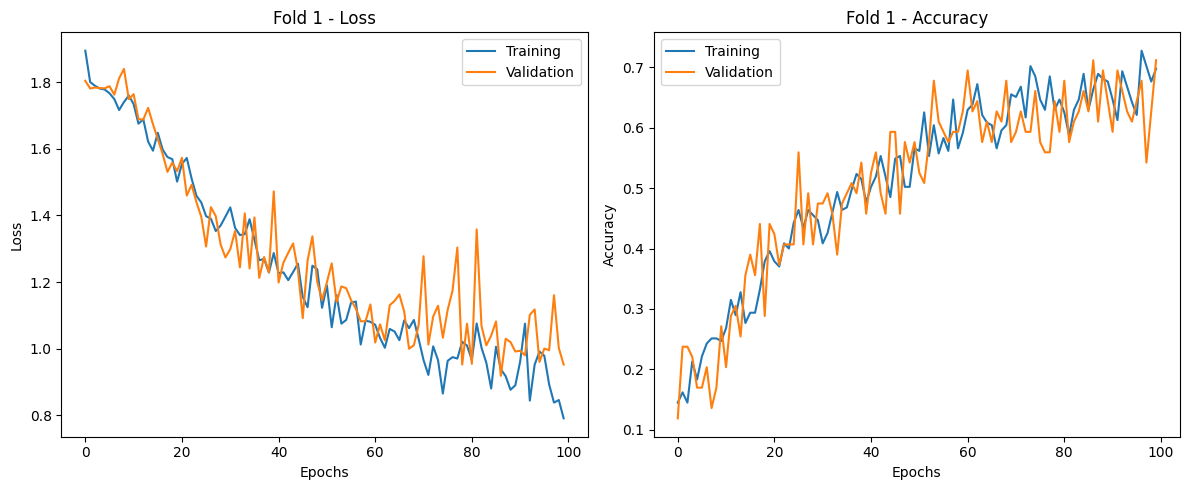

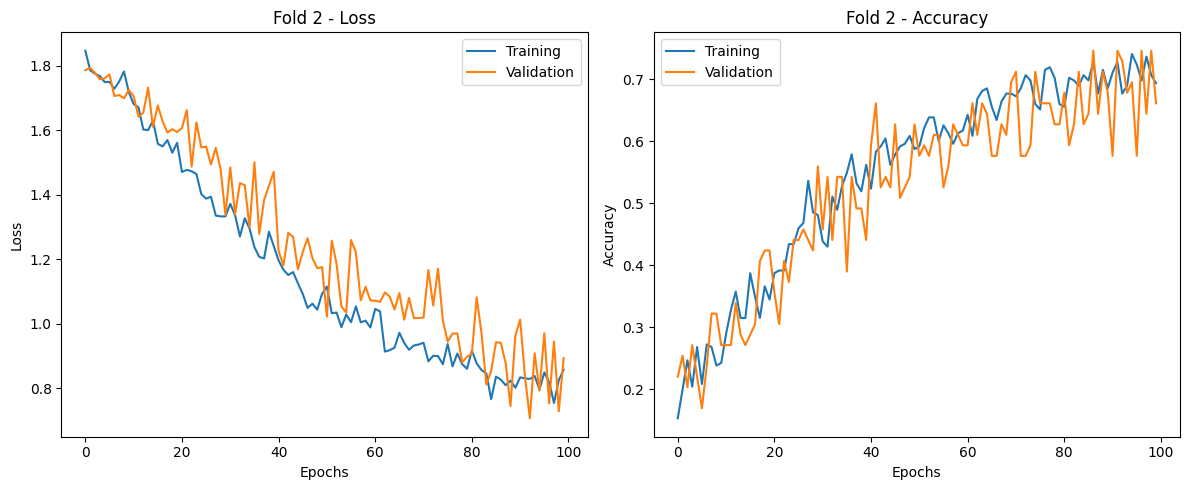

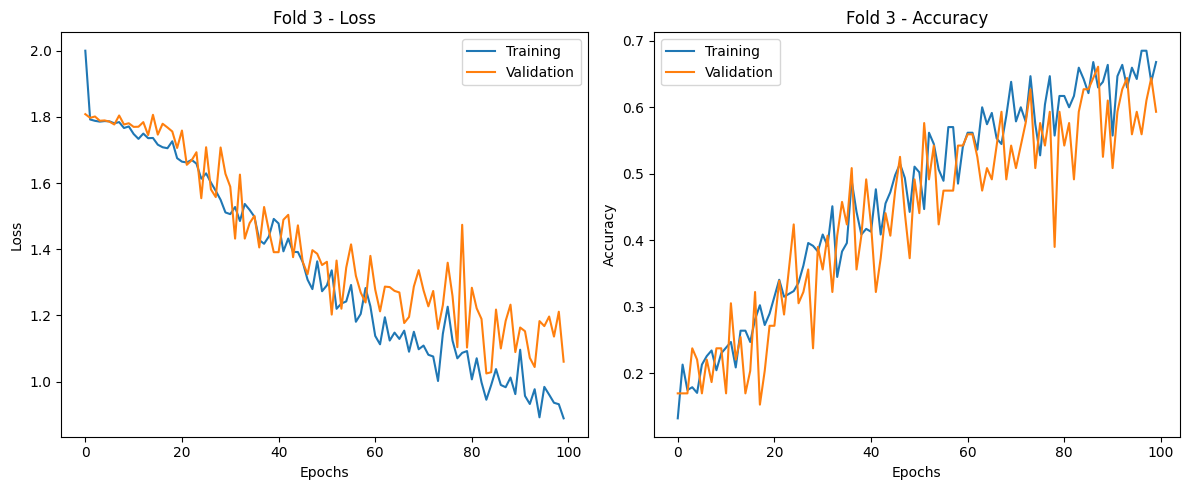

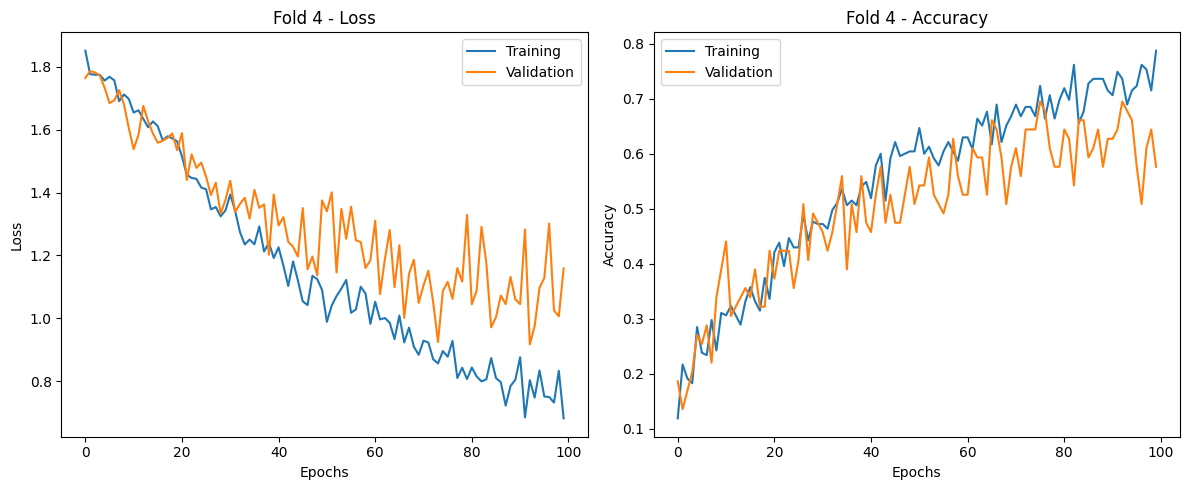

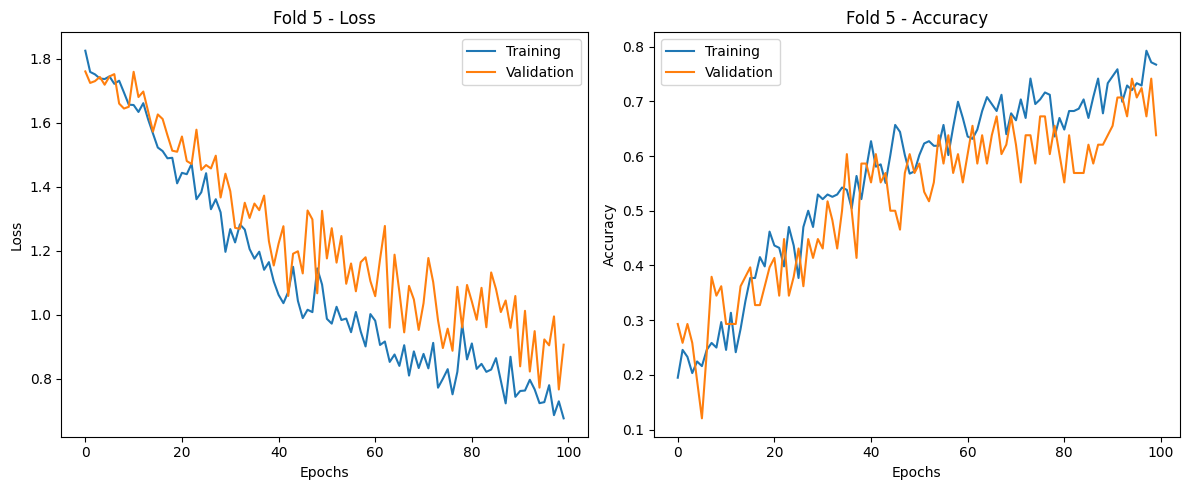

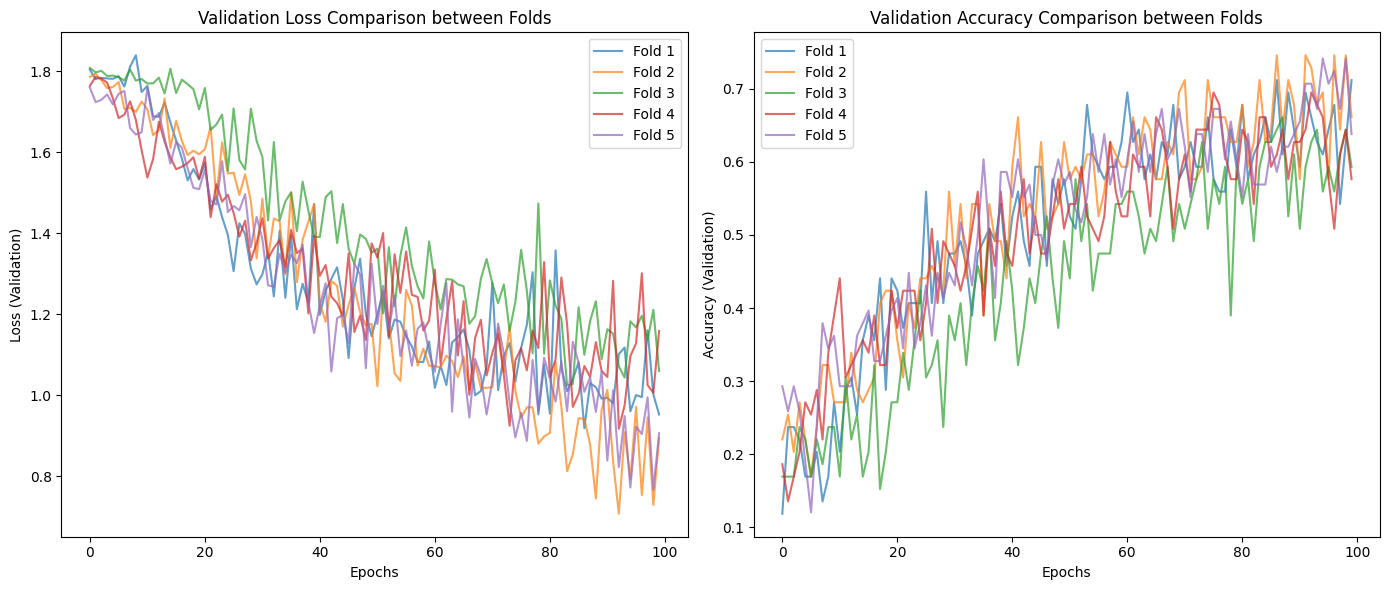

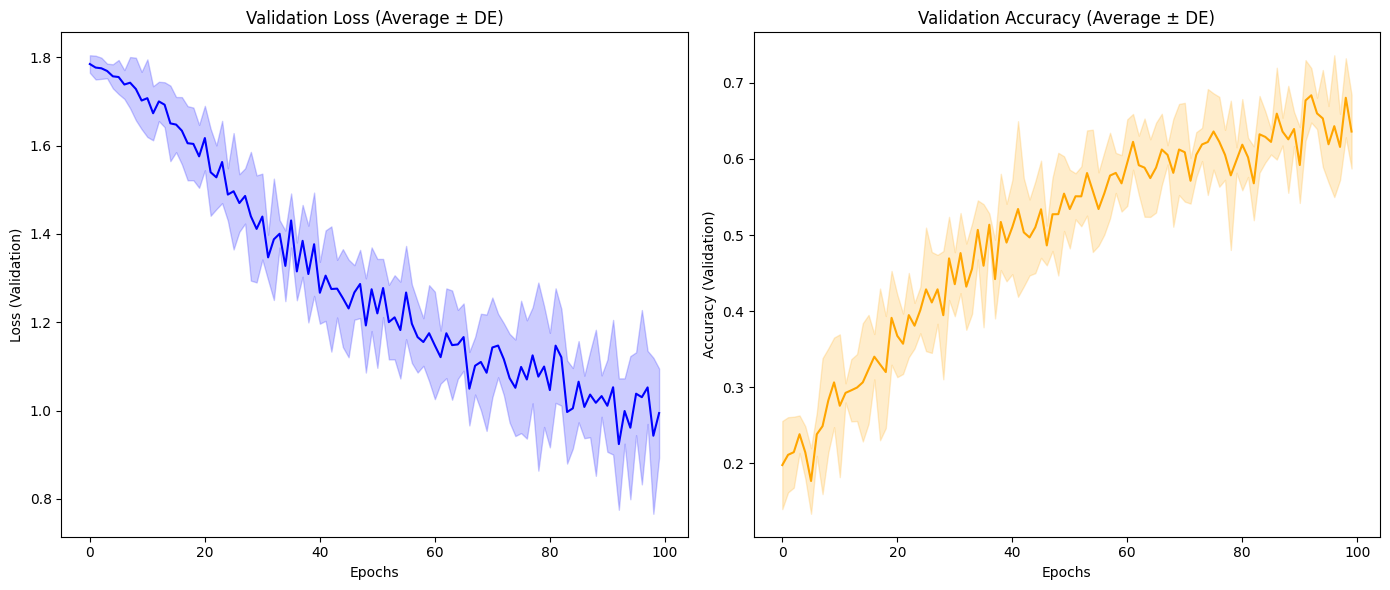

In [ ]:
# Function to plot each fold individually
def plot_fold_history(history, fold_num):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'Fold {fold_num} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'Fold {fold_num} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot all folds together
def plot_all_folds(histories):
    plt.figure(figsize=(14, 6))

    # Loss
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history.history['val_loss'], label=f'Fold {i+1}', alpha=0.7)
    plt.title('Validation Loss Comparison between Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Validation)')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=f'Fold {i+1}', alpha=0.7)
    plt.title('Validation Accuracy Comparison between Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (Validation)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Average and standard deviation plot function
def plot_mean_std(histories):
    max_epochs = max(len(h.history['val_loss']) for h in histories)

    # Initialize arrays to store metrics
    val_loss = np.zeros((len(histories), max_epochs))
    val_acc = np.zeros((len(histories), max_epochs))

    # Filling arrays
    for i, h in enumerate(histories):
        epochs = len(h.history['val_loss'])
        val_loss[i, :epochs] = h.history['val_loss']
        val_acc[i, :epochs] = h.history['val_accuracy']

        # If some folds have fewer epochs, extrapolate the last value
        if epochs < max_epochs:
            val_loss[i, epochs:] = h.history['val_loss'][-1]
            val_acc[i, epochs:] = h.history['val_accuracy'][-1]

    plt.figure(figsize=(14, 6))

    # Loss
    plt.subplot(1, 2, 1)
    mean_loss = np.mean(val_loss, axis=0)
    std_loss = np.std(val_loss, axis=0)
    plt.plot(mean_loss, label='Average', color='blue')
    plt.fill_between(range(max_epochs),
                     mean_loss - std_loss,
                     mean_loss + std_loss,
                     alpha=0.2, color='blue')
    plt.title('Validation Loss (Average ± DE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Validation)')

    # Accuracy
    plt.subplot(1, 2, 2)
    mean_acc = np.mean(val_acc, axis=0)
    std_acc = np.std(val_acc, axis=0)
    plt.plot(mean_acc, label='Average', color='orange')
    plt.fill_between(range(max_epochs),
                     mean_acc - std_acc,
                     mean_acc + std_acc,
                     alpha=0.2, color='orange')
    plt.title('Validation Accuracy (Average ± DE)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (Validation)')

    plt.tight_layout()
    plt.show()

# Execute plotting functions
for fold_num, history in enumerate(histories, 1):
    plot_fold_history(history, fold_num)

plot_all_folds(histories)
plot_mean_std(histories)